In [6]:
%ls

Download_HMP2.ipynb           Prelim_data_analysis.ipynb        README.md
hmp2@                         Prelim_data_analysis_SJBae.ipynb  utils/
hmp2_metadata_2018-08-20.csv  products_MGX_2017-08-12.html


In [17]:
%ls /pool001/robcli/hmp2 | head -n 5

CSM5FZ4M_contigs.fna.gz
CSM5MCUO_contigs.fna.gz
CSM5MCVL_contigs.fna.gz
CSM5MCVN_contigs.fna.gz
CSM5MCW6_contigs.fna.gz
ls: write error: Broken pipe


In [2]:
import utils.parser as parser

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data filtering and sampling

## Import data

In [4]:
sample_df = pd.read_csv("hmp2_metadata_2018-08-20.csv", low_memory=False)

In [22]:
# Get list of filenames in the folder
hmp2_path = "/pool001/robcli/hmp2"
existing_files = os.listdir(hmp2_path)

## Drop assemblies with small sizes

In [53]:
min_size_bytes = 1 * 1024 * 1024  # 10 MB in bytes

# List all files in the directory
all_files = os.listdir(hmp2_path)

# Keep only files that are >=10MB
large_files = [
    f for f in all_files 
    if os.path.isfile(os.path.join(hmp2_path, f)) and os.path.getsize(os.path.join(hmp2_path, f)) >= min_size_bytes
]

print(f"Found {len(large_files)} files >=1MB")

Found 1307 files >=10MB


In [23]:
assembly_df = sample_df.query("data_type == 'metagenomics'").\
              assign(AssemblyName = sample_df["External ID"] + "_contigs.fna.gz")

In [56]:
# Filter the assembly_df using these filenames
assembly_df = assembly_df[assembly_df["AssemblyName"].isin(large_files)]
assembly_df[["Participant ID", "External ID", "diagnosis"]]

,Participant ID,External ID,diagnosis
1077,C3001,CSM5MCXD,CD
1078,C3001,CSM5MCYS,CD
1079,C3001,CSM67U9J,CD
1080,C3001,CSM67UA2,CD
1081,C3001,CSM67UGC,CD
...,...,...,...
2701,P6038,PSMA26A1,UC
2702,P6038,PSMA26A3,UC
2703,P6038,PSMB4MC1,UC
2704,P6038,PSMB4MC3,UC


1338 -> 1307 

31 samples are lost

## Check and filter by number of replicates

In [57]:
# Drop duplicates so each participant appears only once
assembly_df_unique = assembly_df.drop_duplicates(subset="Participant ID")

# Step 2: Count how many participants fall into each diagnosis category
diagnosis_counts = assembly_df_unique["diagnosis"].value_counts()

# Step 3: Print counts
print("Diagnosis counts (1 per participant) among participants with <10 replicates:")
print(f"UC: {diagnosis_counts.get('UC', 0)}")
print(f"CD: {diagnosis_counts.get('CD', 0)}")
print(f"nonIBD: {diagnosis_counts.get('nonIBD', 0)}")

Diagnosis counts (1 per participant) among participants with <10 replicates:
UC: 30
CD: 50
nonIBD: 26


In [58]:
# Step 1: Count how many samples per participant
replicate_counts = assembly_df["Participant ID"].value_counts()
min_replicates = replicate_counts.min()
min_replicates

3

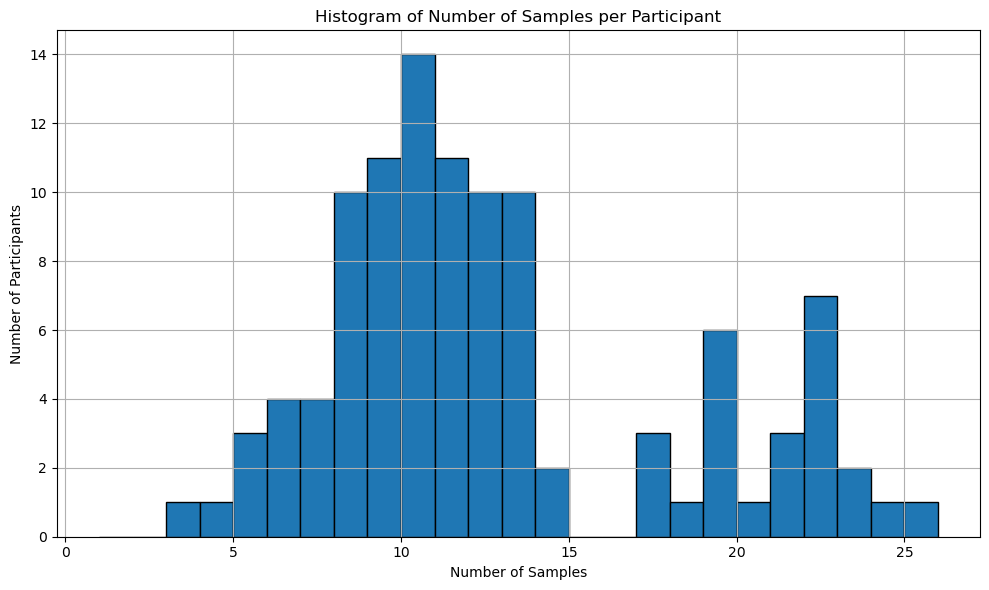

In [59]:
# Step 2: Plot histogram of number of samples per participant
plt.figure(figsize=(10, 6))
plt.hist(replicate_counts, bins=range(1, replicate_counts.max() + 2), edgecolor='black')
plt.title("Histogram of Number of Samples per Participant")
plt.xlabel("Number of Samples")
plt.ylabel("Number of Participants")
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
# Step 2: Find participants with low replicates
low_rep_ids = replicate_counts[replicate_counts < 10].index.tolist()
print(len(low_rep_ids)) 

34


In [46]:
# Step 3: Filter the full sample_df (not just assembly_df) for those participants
low_rep_samples = assembly_df[assembly_df["Participant ID"].isin(low_rep_ids)]

# Step 4: Drop duplicates so each participant appears only once
low_rep_unique = low_rep_samples.drop_duplicates(subset="Participant ID")

In [47]:
# Step 2: Count how many participants fall into each diagnosis category
diagnosis_counts = low_rep_unique["diagnosis"].value_counts()

# Step 3: Print counts
print("Diagnosis counts (1 per participant) among participants with <10 replicates:")
print(f"UC: {diagnosis_counts.get('UC', 0)}")
print(f"CD: {diagnosis_counts.get('CD', 0)}")
print(f"nonIBD: {diagnosis_counts.get('nonIBD', 0)}")

Diagnosis counts (1 per participant) among participants with <10 replicates:
UC: 13
CD: 14
nonIBD: 5


after filtering with >1MB files, we get 1 person with 3 samples and 1 person with 4 samples 

so <5 now drops 2 ppl 

'<10' -> more data but probably biased and losing 30% of participants.

so i’ll move on with <5!

In [49]:
# Step 1: Count samples per participant
replicate_counts = assembly_df["Participant ID"].value_counts()

# Step 2: Get list of participants with >5 samples
eligible_ids = replicate_counts[replicate_counts > 5].index

# Step 3: Filter assembly_df for those participants only
filtered_df = assembly_df[assembly_df["Participant ID"].isin(eligible_ids)]

# Step 4: Randomly select 5 samples per participant
sampled_df = filtered_df.groupby("Participant ID").sample(n=5, random_state=42)

# Step 5 (optional): Reset index for clean output
sampled_df = sampled_df.reset_index(drop=True)

# Preview
sampled_df[["Participant ID", "External ID", "AssemblyName"]].head(20)


,Participant ID,External ID,AssemblyName
0,C3001,CSM5MCXD,CSM5MCXD_contigs.fna.gz
1,C3001,CSM5MCYS,CSM5MCYS_contigs.fna.gz
2,C3001,CSM79HG5,CSM79HG5_contigs.fna.gz
3,C3001,CSM67U9J,CSM67U9J_contigs.fna.gz
4,C3001,CSM67UGC,CSM67UGC_contigs.fna.gz
5,C3002,CSM67UBR,CSM67UBR_contigs.fna.gz
6,C3002,CSM5MCVL,CSM5MCVL_contigs.fna.gz
7,C3002,CSM67UBH,CSM67UBH_contigs.fna.gz
8,C3002,CSM79HJW,CSM79HJW_contigs.fna.gz
9,C3002,CSM67UBF,CSM67UBF_contigs.fna.gz


## Save the metadata for the sampled_df

In [68]:
output_path = "sampled_metadata.csv"
sampled_df.to_csv(output_path, index=False)